<a href="https://colab.research.google.com/github/williammcintosh/machine_learning_projects/blob/main/RAG_Loop_Chroma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Loop w/ Chroma + GPT

## Will McIntosh

## Purpose

Although many LLM's have the ability to upload an entire pdf document into a query, doing so provides limitations in that the LLM can forget context of the document, flooding it with too much information. Instead, with the use of Retreival Augmented Generation (RAG) we can strategically select the pages or segments of the pdf document that are relevant to the query given. We use Cross-Encoder Re-Ranking with cosine similarity to find the documents in the pdf that are most relevant to the query. We also can expand our query search by asking the LLM what more queries we can be asking about our document.

This notebook acts as a review of some of the elements in a embeddings-based retreival system and how that fits together in a RAG loop, together with an LLM.

[RAG Study by Pinecone](https://www.pinecone.io/blog/rag-study/)

## How it Works

<center>
    <img src="https://drive.google.com/uc?export=view&id=1QWTIh86_N9z7yDDchozSTeHY1prZBMmF" width="50%">
</center>


The way RAG works is you have some user query which comes in and some set of documents. These documents need to be embedded and stored in your retreival system (in this case we use Chroma). We run the query through the same embedding model (Chroma). The retreival system finds the most relevant document according to the embedding from that query by finding the nearest neighbors embeddings. We return both the query and the relevant documents to the LLM. The LLM synthesizes information from the retrieved documents to generate an answer.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
! pip install chromadb==0.4.22
! pip install pypdf==3.17.4
! pip install langchain==0.1.0
! pip install sentence_transformers==2.2.2
# ! pip install -U ipykernel==6.28.0
! pip install requests==2.31.0
! pip install openai==1.7.0
! pip install umap==0.1.1
! pip install umap-learn==0.5.5

# Helpers

## General Helpers

### General Imports

In [3]:
import requests
from pypdf import PdfReader

### Example PDF

In [4]:
def get_academic_latex_paper():
  pdf_title = 'RR-2757_latex.pdf'
  url = 'https://drive.google.com/uc?export=download&id=1V8OMDVUgzL-FfCNHWlSUkhG-k0jirHMl'

  response = requests.get(url)

  with open(pdf_title, "wb") as f:
      f.write(response.content)

  return pdf_title

In [5]:
def get_microsoft_2022_report():
  pdf_title = '221115247.pdf'
  url = 'https://annualreport.stocklight.com/nasdaq/msft/'+pdf_title

  response = requests.get(url)

  with open(pdf_title, "wb") as f:
      f.write(response.content)

  return pdf_title

## OpenAI Helpers

### OpenAI Imports

In [6]:
import os
import openai
from openai import OpenAI

### OpenAI Keys

In [7]:
api_key_file = '/content/drive/MyDrive/JarvisGPT/gptapi_key.txt'

with open(api_key_file, 'r') as file:
    openai.api_key = file.read().strip()

### OpenAI Prompt

We are turning ChatGPT into a model that retains specific information that is our document.

Different models to select from [can be found here](https://platform.openai.com/docs/models/gpt-3-5).

In [8]:
def rag(query, retrieved_documents, model="gpt-4-1106-preview"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert research assistant. Your users are asking questions about information contained in a document."
            "You will be shown the user's question, and the relevant information from the document. Answer the user's question using only this information."
            "For each response to each question, provide a short quote from the cited document that you're referencing."
        },
        {
            "role": "user",
            "content": f"Question: {query}. \n Information: {information}"
        }
    ]

    response = openai.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [9]:
def augment_multiple_query(query, model="gpt-4-1106-preview"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert research assistant. Your users are asking questions about a report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

## Chromadb Helpers

### Chromadb Imports

In [10]:
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# import umap
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Chromadb Methods

In [11]:
def convert_pdf_to_chroma_embeddings(pdf_title):
    # Stripping the white space and empty strings or pages
    reader = PdfReader(pdf_title)
    pdf_texts = [p.extract_text().strip() for p in reader.pages if p.extract_text()]

    # Recursively splits chunks based on the separators
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    # Create Chroma Embeddings
    chroma_client = chromadb.Client()
    chroma_embeddings = chroma_client.create_collection(pdf_title, embedding_function=embedding_function)
    ids = [str(i) for i in range(len(token_split_texts))]
    chroma_embeddings.add(ids=ids, documents=token_split_texts)
    chroma_embeddings.count()

    return chroma_embeddings

In [12]:
import umap

def plot_umap_embeddings(chroma_embeddings, augmented_queries, original_query, topten_docs, results):
    # Create embeddings
    augmented_query_embeddings = embedding_function(augmented_queries)
    original_query_embedding = embedding_function([original_query])
    topten_embeddings = embedding_function(topten_docs)
    result_embeddings = results['embeddings']
    result_embeddings = [item for sublist in result_embeddings for item in sublist]
    dataset_embeddings = chroma_embeddings.get(include=['embeddings'])['embeddings']

    # UMAP fit to dataset
    reducer = umap.UMAP(n_components=2, random_state=0)
    umap_embeddings = reducer.fit_transform(dataset_embeddings)

    # UMAP transform for projections
    projected_augmented_queries = reducer.transform(augmented_query_embeddings)
    projected_original_query = reducer.transform(original_query_embedding)
    projected_result_embeddings = reducer.transform(result_embeddings)
    projected_topten_embeddings = reducer.transform(topten_embeddings)

    plt.figure()
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=10, color='gray', label='Dataset')
    plt.scatter(projected_augmented_queries[:, 0], projected_augmented_queries[:, 1], s=150, marker='X', color='orange', label='Augmented Queries')
    plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='lightgreen', alpha=0.75, label='Retrieved Documents')
    plt.scatter(projected_topten_embeddings[:, 0], projected_topten_embeddings[:, 1], s=100, facecolors='none', edgecolors='green', alpha=1.0, label='Top Ten Documents')
    plt.scatter(projected_original_query[:, 0], projected_original_query[:, 1], s=150, marker='X', color='r', label='Original Query')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{original_query}')
    plt.axis('off')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


In [14]:
def expanded_query_cross_encoder_reranking(original_query, chroma_embeddings):
    augmented_queries = augment_multiple_query(original_query)
    queries = [original_query] + augmented_queries
    results = chroma_embeddings.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])

    # Deduplicate the retrieved documents
    unique_documents = set()
    for documents in results['documents']:
        for document in documents:
            unique_documents.add(document)

    # Get scores for each document compared with original query
    pairs = [[original_query, doc] for doc in unique_documents]
    scores = cross_encoder.predict(pairs)
    scored_documents = [(score, doc) for score, doc in zip(scores, unique_documents)]
    sorted_documents = sorted(scored_documents, key=lambda x: x[0], reverse=True)

    # Store the top-ranked documents
    top_docs = []
    for score, document in sorted_documents:
        top_docs.append(document)

    topten_docs = top_docs[:10]
    print(rag(query=queries, retrieved_documents=topten_docs))

    plot_umap_embeddings(chroma_embeddings, augmented_queries, original_query, topten_docs, results)

# Call RAG Loop

## Initialize Chromadb

In [15]:
%%capture
# Makes a dense vector embedding
embedding_function = SentenceTransformerEmbeddingFunction()

In [16]:
%%capture
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

## Query LLM Example 1

# Query Expansion

<center>
    <img src="https://drive.google.com/uc?export=view&id=1wFLcW5y85_6ESfObw14tY6o4AmyXKbSg" width="50%">
</center>

We can use multiple queries in expaning our query and gain more insights into useful and relevant documents to our query. We use the LLM to generate additional queries that might help us answer our initial question. We take our original query, we pass it into the LLM, we ask the LLM to generate several new related queries to the same original query and then we pass those new queries along with our original query to the RAG system loop.

Generate Multiple Queries and use Cross-Encoder Re-Ranking to find the most relevant documents

In [17]:
%%capture
microsoft_report_pdf = get_microsoft_2022_report()
chroma_embeddings = convert_pdf_to_chroma_embeddings(pdf_title=microsoft_report_pdf)

1. What were the most important factors that contributed to increases in revenue?

The increases in revenue were driven by various factors, including "continued strength in the commercial PC market," "demand for Microsoft 365," growth in "search volume and higher revenue per search," increases in "xbox hardware," and "growth in Azure and other cloud services."

2. What new products or services were launched last year?

The document does not provide specific information about new products or services launched during the year.

3. How did changes in pricing strategies affect revenue?

The document mentions "growth in revenue per user" for Microsoft 365 commercial and improvement in productivity and business processes, suggesting that pricing strategy might have positively affected revenue, but the exact impact of changes in pricing strategies on revenue is not explicitly detailed.

4. What was the impact of market expansion on sales?

While the document does not directly discuss "market 

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


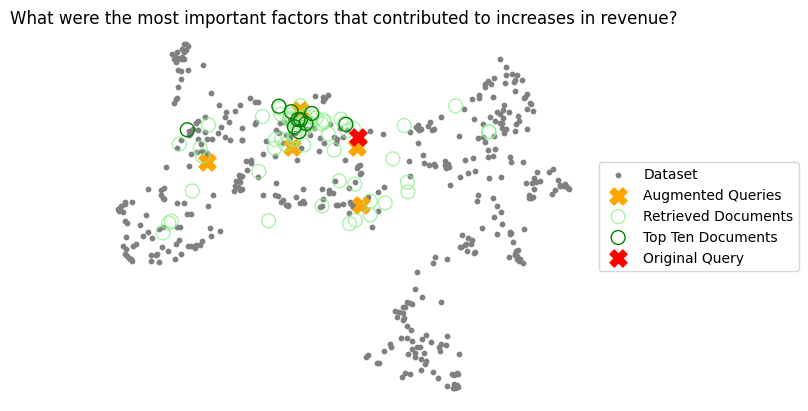

In [18]:
original_query = "What were the most important factors that contributed to increases in revenue?"
expanded_query_cross_encoder_reranking(original_query, chroma_embeddings)

# Academic Paper

Here I'm trying the RAG loop with an academic paper that was converted to latex code to preserve algorithms and formulas

In [19]:
%%capture
bruno_latex_paper = get_academic_latex_paper()
bruno_chroma_embeddings = convert_pdf_to_chroma_embeddings(pdf_title=bruno_latex_paper)

1. Please explain the details of this article?
The article describes an "active testing model" for tracking roads in satellite images. The approach draws from the concept of the parlor game "twenty questions," where the goal is to minimize the number of questions to determine a specific instance within a category. The document discusses optimal strategies for such decision-making processes and relates it to categorization in computer vision tasks. This methodology is applied to the problem of tracking roads by choosing and ordering tests—such as detecting road segments through matched filters. The article also explores the mathematical aspects and algorithms for decision trees in the context of recognition and classification problems.

2. What is the main topic of the article?
The main topic of the article is the development and application of an "active testing model" for tracking roads in satellite images.

3. Who are the authors of the article?
The authors of the article are Donald 

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


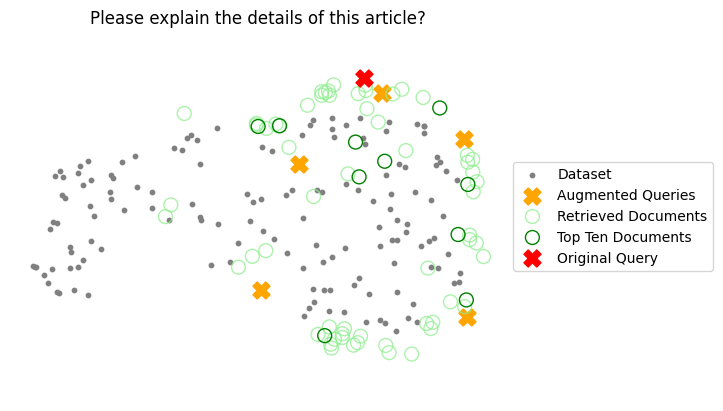

In [20]:
original_query = "Please explain the details of this article?"
expanded_query_cross_encoder_reranking(original_query, bruno_chroma_embeddings)